In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
from classy import Class
import jax.numpy as jnp
import numpy as np
from jax import jit, vmap, lax, grad, config, jacfwd
from jax.scipy.special import gamma, factorial
import scipy
import equinox as eqx
from tqdm.notebook import tqdm
import matplotlib.pyplot as plt
import time

from JaxCMB import main, cosmology, perturbations, spectrum
from JaxCMB import constants as cnst
from JaxCMB import ABCMBTools as tools
from JaxCMB.hyrax import hyrax

# Setup

In [7]:
# Load the pre-baked modules, no need for running get_PTBG
# Note: This was computed with Neff=3.044 and N_ncdm=1, so there are both massive and massless neutrinos.
BG = cosmology.MockBackground()
model = main.Model(ellmin=2, ellmax=2000, lensing=False, has_MasslessNeutrinos=False, has_MassiveNeutrinos=False)
#BG = cosmology.ClassBackground()
PE = perturbations.PerturbationEvolver(model.perturbations_list, BG)
#PT = PE.full_evolution()
PT = perturbations.MockPerturbationTable()

In [95]:
SS = spectrum.SpectrumSolver(ellmin=2, ellmax=2500, lensing=False, switch_sw=1., switch_isw=1., switch_dop=1., switch_pol=1.)

In [82]:
class_params = {
    "output": "mPk, tCl, pCl",
    "temperature_contributions" : "tsw",
    "l_max_scalars" : 3000,
    "z_max_pk": 1000,
    "H0": BG.params["h"]*100,
    "omega_b": BG.params["omega_b"],
    "omega_cdm": BG.params["omega_cdm"],
    "tau_reio": 0.0586,
    "N_ur": BG.params["N_ur"],
    #"N_ur" : 3.044,
    "YHe": BG.params["YHe"],
    "lensing": "no",
    "N_ncdm": 0}    

class_lcdm = Class()
class_lcdm.set(class_params)
class_lcdm.compute()

# Cl's

In [73]:
#class_pp = class_lcdm.raw_cl(3000)["pp"]
class_tt = class_lcdm.raw_cl(3000)["tt"]
class_te = class_lcdm.raw_cl(3000)["te"]
class_ee = class_lcdm.raw_cl(3000)["ee"]
class_ell = class_lcdm.raw_cl(3000)["ell"]

In [179]:
f = eqx.filter_jit(SS.get_Cl)
for i in range(2):
    s=time.time()
    cls = f(PT, BG)
    cls[0].block_until_ready()
    print(time.time()-s)

3.3224196434020996
3.3025989532470703


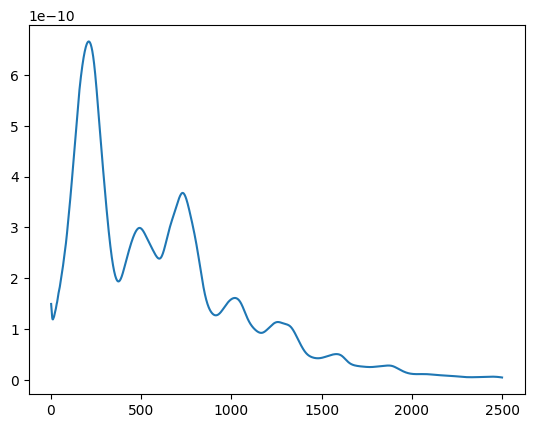

In [180]:
l = SS.ells
plt.plot(l, l*(l+1)*cls[0]/2./jnp.pi)
#plt.plot(l, l*(l+1)*jnp.interp(l, class_ell, class_tt)/2./jnp.pi)
#plt.xlim((180, 220))
plt.show()

In [9]:
SS_lens   = spectrum.SpectrumSolver(ellmax=2500, lensing=True, switch_sw=1., switch_isw=1., switch_dop=1.)
SS_nolens = spectrum.SpectrumSolver(ellmax=2500, lensing=False, switch_sw=1., switch_isw=1., switch_dop=1.)

In [44]:
f = eqx.filter_jit(SS_lens.get_Cl)
for i in range(2):
    s=time.time()
    cls_lensed = f(PT, BG)
    cls_lensed[0].block_until_ready()
    print(time.time()-s)

f = eqx.filter_jit(SS_nolens.get_Cl)
for i in range(2):
    s=time.time()
    cls_unlensed = f(PT, BG)
    cls_unlensed[0].block_until_ready()
    print(time.time()-s)

35.85578155517578
27.012572288513184
36.038904428482056
27.294697284698486


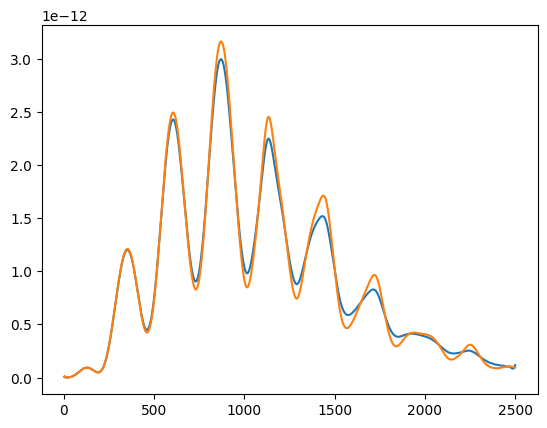

In [43]:
l = SS_lens.ells
plt.plot(l, l*(l+1)*cls_lensed[2]/2./jnp.pi)
plt.plot(l, l*(l+1)*cls_unlensed[2]/2./jnp.pi)
plt.show()

In [8]:
params = {
    'h': 0.6762,
    'omega_cdm': 0.1193,
    'omega_b': 0.0225,
    'A_s': 2.12424e-9,
    'n_s': 0.9709,
    'Neff': 0.,
    'YHe': 0.245,
    'TCMB0': 2.34865418e-4,
    'T_nu': (4. / 11.)**(1. / 3.) * 2.34865418e-4,
    'N_ncdm': 0.,
    'T_ncdm': 0.71611 * 2.34865418e-4,
    'm_ncdm': 0.06,
}
PT, BG = eqx.filter_jit(model.get_PTBG)(params)

/ext3/miniconda3/lib/python3.10/site-packages/equinox/_jit.py:55: UserWarning: `diffrax.diffeqsolve(..., discrete_terminating_event=...)` is deprecated in favour of the more general `diffrax.diffeqsolve(..., event=...)` interface. This will be removed in some future version of Diffrax.
  out = fun(*args, **kwargs)
/ext3/miniconda3/lib/python3.10/site-packages/equinox/_jit.py:55: UserWarning: `diffrax.diffeqsolve(..., discrete_terminating_event=...)` is deprecated in favour of the more general `diffrax.diffeqsolve(..., event=...)` interface. This will be removed in some future version of Diffrax.
  out = fun(*args, **kwargs)
2025-10-04 11:54:45.097115: E external/xla/xla/service/slow_operation_alarm.cc:73] 
********************************
[Compiling module jit_get_PTBG] Very slow compile? If you want to file a bug, run with envvar XLA_FLAGS=--xla_dump_to=/tmp/foo and attach the results.
********************************
2025-10-04 11:55:07.433904: E external/xla/xla/service/slow_operati

In [50]:
SS.ells_indices

Array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
       17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33,
       34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50,
       51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67,
       68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84,
       85, 86, 87, 88, 89, 90, 91, 92, 93, 94, 95, 96, 97, 98],      dtype=int64)

In [165]:
k, integrand = SS.Cl_one_ell(1, PT, BG)

In [173]:
4000/BG.rA_rec

Array(0.2871065, dtype=float64)

In [131]:
spectrum.bessel_l_tab[0]

Array(2500, dtype=int64)

In [106]:
0.15*BG.tau0/2./jnp.pi * 5

Array(1700.7925865, dtype=float64)

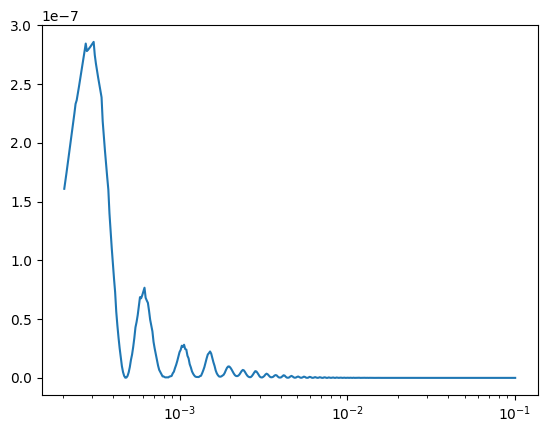

In [166]:
plt.plot(k, integrand[0])
plt.xscale("log")
#plt.yscale("log")
#plt.xlim((0.005, 0.04))
plt.show()

In [174]:
f = eqx.filter_jit(SS.get_Cl)
for i in range(3): 
    s = time.time()
    res = f(PT, BG)
    print(time.time()-s)

7.33430027961731
3.3083770275115967
3.318007469177246


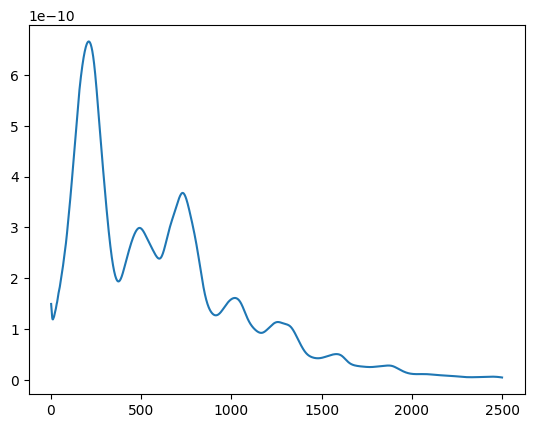

In [178]:
l = SS.ells
plt.plot(l, l*(l+1)*res[0]/2./jnp.pi)
plt.show()

# P(k)

In [5]:
class_pk = np.loadtxt("/home/zz1994/packages/class/output/ABCMB_test/noneutrinos00_pk.dat")
k_class = class_pk[:, 0]*BG.params["h"]
Pk_class = class_pk[:, 1]/BG.params["h"]**3

In [15]:
k = jnp.logspace(-4., -0.3, 500, base=10)
Pk = SS.Pk_lin(k, 0., PT, BG)

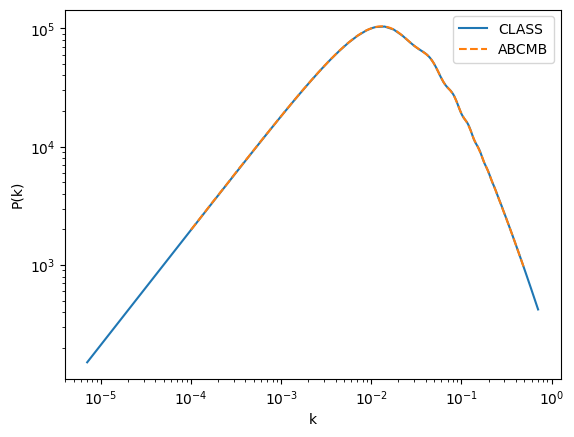

In [16]:
plt.loglog(k_class, Pk_class, label="CLASS")
plt.loglog(k, Pk, "--", label="ABCMB")
plt.legend()
#plt.xlim((1.e-3, 1))
plt.xlabel("k")
plt.ylabel("P(k)")
plt.show()

In [7]:
from classy import Class

In [16]:
class_params = {
    "output": "mPk, lCl",
    "lensing": "yes",
    "z_max_pk": 1000,
    "H0": BG.params["h"]*100,
    "omega_b": BG.params["omega_b"],
    "omega_cdm": BG.params["omega_cdm"],
    "tau_reio": 0.0586,
    "N_ur": BG.params["N_ur"],
    "YHe": BG.params["YHe"],
    "lensing": "no",
    "N_ncdm": 0}    

In [17]:
class_lcdm = Class()
class_lcdm.set(class_params)
class_lcdm.compute()

In [18]:
zs = jnp.array([0., 10., 100., 1000.])
k = jnp.logspace(-4., -0.3, 500, base=10)

/state/partition1/job-66401383/ipykernel_1291522/4275723911.py:7: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend()


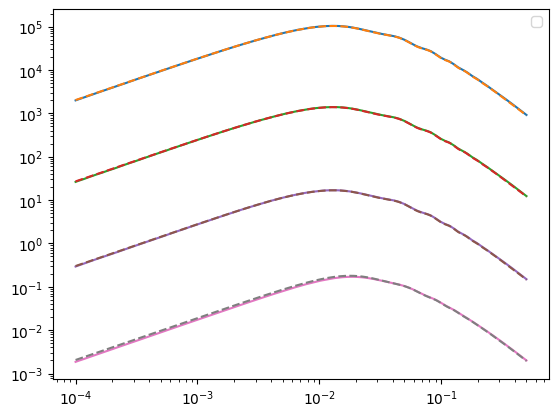

In [25]:
for z in zs:
    abcmb_res = SS.Pk_lin(k, z, PT, BG)
    class_res = np.vectorize(class_lcdm.pk_lin)(k, z)
    plt.loglog(k, SS.Pk_lin(k, z, PT, BG))
    plt.loglog(k, np.vectorize(class_lcdm.pk_lin)(k, z), "--")
    #plt.loglog(k, abs(abcmb_res - class_res)/class_res, label=z)
plt.legend()
plt.show()

# Lensing

## Lensing Cl

In [30]:
class_pp = class_lcdm.raw_cl(3000)["pp"]
class_tt = class_lcdm.raw_cl(3000)["tt"]
class_te = class_lcdm.raw_cl(3000)["te"]
class_ee = class_lcdm.raw_cl(3000)["ee"]
class_ell = class_lcdm.raw_cl(3000)["ell"]
abcmb_pp = vmap(SS.lensing_Cl, in_axes=(0, None, None))(class_ell, PT, BG)

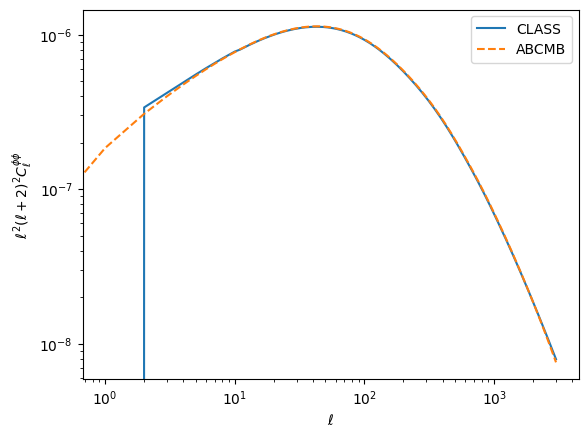

In [31]:
plt.plot(class_ell, (class_ell*(class_ell+1))**2 * class_pp, label="CLASS")
plt.plot(class_ell, (class_ell*(class_ell+1))**2 * abcmb_pp, "--", label="ABCMB")
plt.legend()
plt.xscale("log")
plt.yscale("log")
#plt.xlim((2, 2000))
plt.xlabel(r"$\ell$")
plt.ylabel(r"$\ell^2(\ell+2)^2C_\ell^{\phi\phi}$")
plt.show()

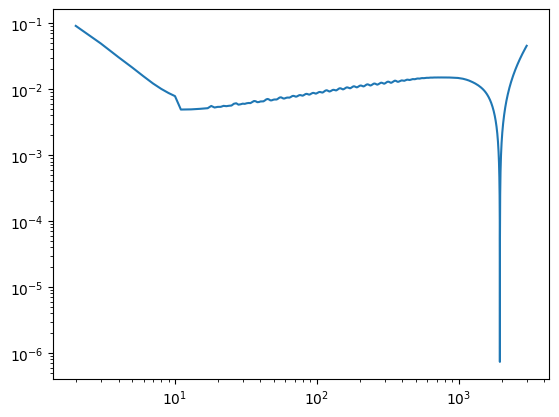

In [32]:
plt.plot(class_ell, abs(class_pp - abcmb_pp)/class_pp)
plt.xscale("log")
plt.yscale("log")
#plt.xlim((2, 2000))
plt.show()

## Temperature Cl

$$
C_\ell = \int_{0.98}^{1} \xi(\beta) J_0(\ell \beta) d\cos{\beta}
$$

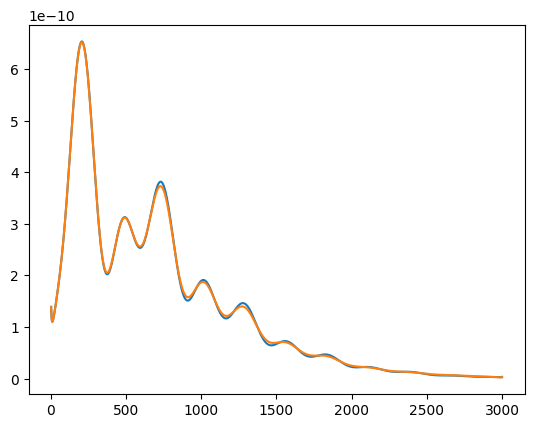

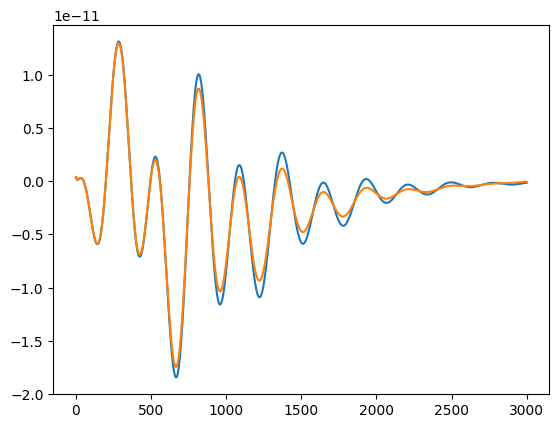

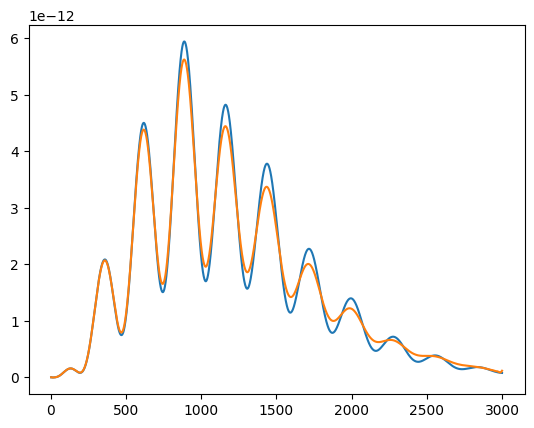

In [36]:
#res = SS.lense_ClTT(class_ell[2:], class_pp[2:], class_ell[2:]*(class_ell[2:]+1)*class_tt[2:]/2./jnp.pi)
#plt.loglog(class_ell[2:], class_ell[2:]*(class_ell[2:]+1)*res)
#ells = jnp.arange(2, 2000)
ells = class_ell[2:]
cltt = class_tt[2:]
clte = class_te[2:]
clee = class_ee[2:]
clpp = class_pp[2:]
pref = ells*(ells+1)/2./jnp.pi
#clpp = jnp.zeros(ells.size)
res_tt, res_te, res_ee = eqx.filter_jit(SS.lensed_Cls)(ells, cltt, clte, clee, PT, BG)
plt.plot(ells, pref*cltt)
plt.plot(ells, pref*(res_tt+cltt))
plt.show()

plt.plot(ells, pref*clte)
plt.plot(ells, pref*(res_te+clte))
plt.show()

plt.plot(ells, pref*clee)
plt.plot(ells, pref*(res_ee+clee))
plt.show()

In [47]:
f = eqx.filter_jit(SS.lensed_Cls)
for i in range(2):
    s = time.time()
    res_tt, res_te, res_ee = f(ells, cltt, clte, clee, PT, BG)
    res_tt.block_until_ready()
    print(time.time() - s)

16.553486347198486
11.142034769058228


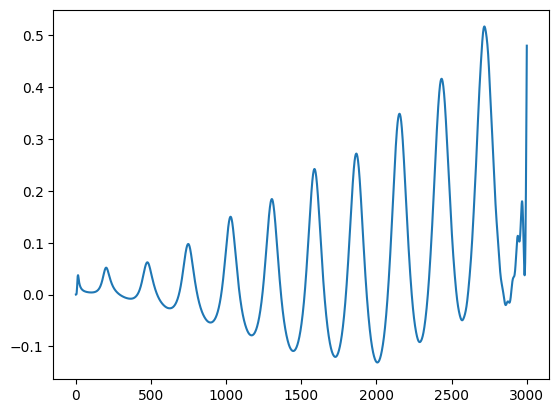

In [304]:
#plt.plot(ells, res_tt/cltt)
#plt.plot(ells, res_te/clte)
plt.plot(ells, res_ee/clee)
plt.show()

## Wigner Matrices

In [104]:
f = jit(tools.lensing_d00)
betas = jnp.linspace(0, jnp.pi/16., 1000)
l     = jnp.arange(2, 1003)
mu    = jnp.cos(betas)
print(f(mu, l).shape)

(1000, 1001)


In [55]:
betas = jnp.linspace(0, jnp.pi/16., 1000)
l     = jnp.arange(2, 1000)
mu    = jnp.cos(betas)

d00  = tools.lensing_d00(mu, l)
d11  = tools.lensing_d11(mu, l)
d1m1 = tools.lensing_d1m1(mu, l)
d2m2 = tools.lensing_d2m2(mu, l)

In the large $\ell$ limit, the Wigner matrices approach Bessel J functions as
$$
\lim_{\ell\rightarrow \infty}d_{mn}^{\ell}(\beta) \longrightarrow (-1)^{n-m} J_{m-n}(\ell \beta)\, .
$$
It serves to check the asymptotic behavior to make sure the recursion relations were correct.

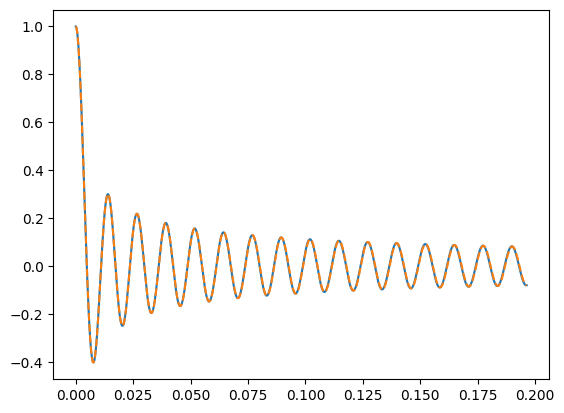

In [19]:
l = 500
plt.plot(betas, d00[:, l-2])
plt.plot(betas, scipy.special.jv(0, l*betas), "--")
plt.show()

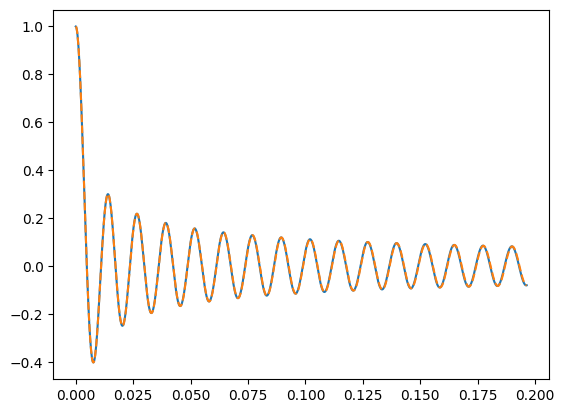

In [20]:
l = 500
plt.plot(betas, d11[:, l-2], label="d11")
plt.plot(betas, scipy.special.jv(0, l*betas), "--")
plt.show()

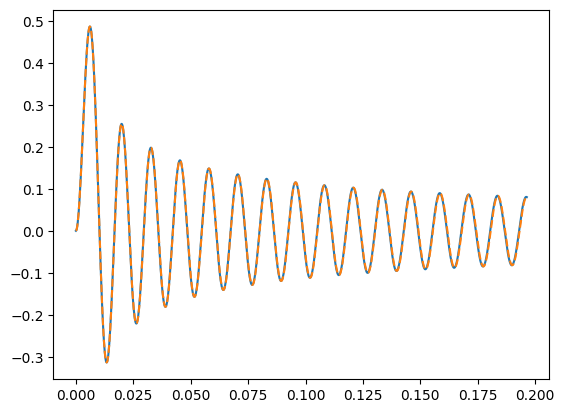

In [21]:
l = 500
plt.plot(betas, d1m1[:, l-2], label="d1m1")
plt.plot(betas, scipy.special.jv(2, l*betas), "--")
plt.show()

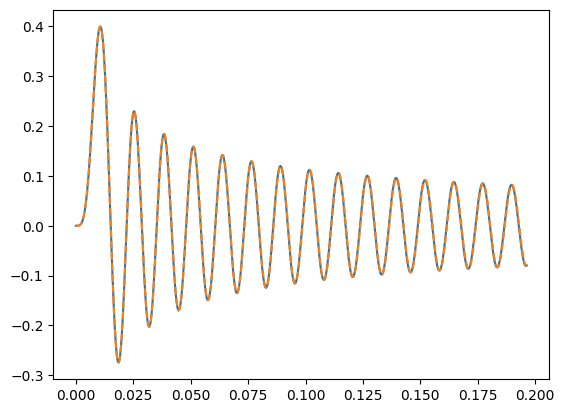

In [62]:
l = 500
plt.plot(betas, d2m2[:, l-2], label="d1m1")
plt.plot(betas, scipy.special.jv(4, l*betas), "--")
plt.show()

In [233]:
# Attempt at general solution
def wigner_d_matrix(mu, ells, m, n):
    """
    m, n are integers. m must be positive and greater than n.
    ells an array ([m, m+1, m+2, ..., ellmax])
    """
    
    # base case: ell = m
    def base_val(mu):
        beta = jnp.arccos(mu)
        norm = jnp.sqrt((2*m+1)/2) * jnp.sqrt(factorial(2*m)/(factorial(m+n)*factorial(m-n)))
        return norm * jnp.cos(beta/2.)**(m+n)*(-jnp.sin(beta/2.))**(m-n)
        #return norm * jnp.sqrt((1+mu)/2)**(m+n) * jnp.sqrt((1-mu)/2)**(m-n)

    normA = jnp.sqrt((2*ells+3)/(2*ells+1))
    normC = jnp.sqrt((2*ells+3)/(2*ells-1))
    denom = jnp.sqrt((ells+1)**2-m**2) * jnp.sqrt((ells+1)**2-n**2)
    A = jnp.nan_to_num(normA * (ells+1)*(2*ells+1) / denom, 0)
    B = jnp.nan_to_num(-A * m * n / ells / (ells+1), 0)
    C = jnp.nan_to_num(-normC * jnp.sqrt(ells**2-m**2) * jnp.sqrt(ells**2-n**2) / denom * (ells+1)/ells, 0)

    def one_mu(mu):
        d_start = base_val(mu) # Corresponds to ellmin = m
                
        def recursive_dlp1(carry, inputs):
            # For the first iteration, will take d1 and d2, compute d3.
            dl, dlm1 = carry 
            a, b, c = inputs

            # Compute dlp1
            dlp1 = a*mu*dl + b*dl + c*dlm1

            # Save dl, then make dl->dlm1, dlp1->dl
            return (dlp1, dl), dl

        # run scan for l = 2..lmax-1
        (_, _), res = lax.scan(recursive_dlp1, (d_start, 0.), (A, B, C))
        return res * jnp.sqrt(2./(2.*ells+1))

    return vmap(one_mu)(mu)

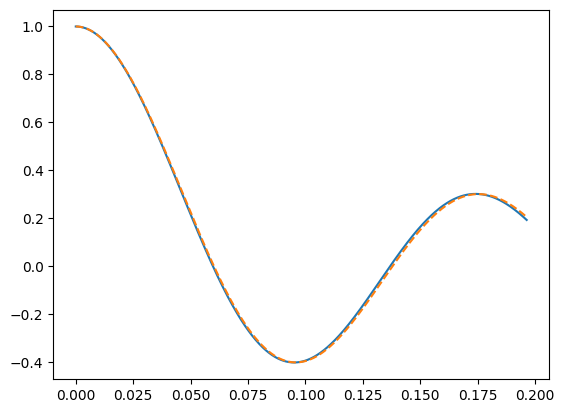

In [245]:
m = 4
n = 4
betas = jnp.linspace(0, jnp.pi/16., 1000)
l     = jnp.arange(m, 1000)
mu    = jnp.cos(betas)
d = jit(wigner_d_matrix)(mu, l, m, n)

l_plot = 10*m
plt.plot(betas, d[:, l_plot-m])
plt.plot(betas, (-1)**(n-m)*scipy.special.jv(m-n, l_plot*betas), "--")
plt.show()

In [248]:
d.shape
zeros = jnp.zeros((mu.size, m-2))
d_patched = jnp.concatenate((zeros, d), axis=1)

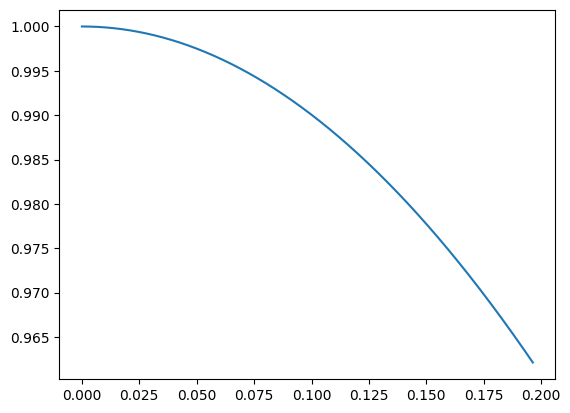

In [252]:
plt.plot(betas, d_patched[:, 2])

In [280]:
arr = jnp.ones(5)

5